In [1]:
import numpy as np
import sys
sys.path.insert(0, "../")
from argparse import Namespace
import os
os.chdir('C:/Users/Lorenz/PycharmProjects/flatland')
import torch
import flatland_starter_kit_master
from flatland.envs.rail_generators import test_rail_generator
from flatland.envs.line_generators import test_line_generator
from flatland.envs.rail_env import RailEnv
from flatland.envs.observations import TreeObsForRailEnv
from flatland.envs.malfunction_generators import TestMalfunctionGen

tree_observation = TreeObsForRailEnv(max_depth=3)
observation_tree_depth = 3
observation_radius = 10

n_agents = 20
test_env = RailEnv(
    width=18,
    height=10,
    number_of_agents=n_agents,
    rail_generator=test_rail_generator(max_num_cities=2),
    line_generator=test_line_generator(),
    malfunction_generator=TestMalfunctionGen((0,0,0)),
    obs_builder_object=tree_observation
)
observations, info = test_env.reset()

os.chdir('C:/Users/Lorenz/PycharmProjects/flatland/flatland_starter_kit_master/baselines')
from reinforcement_learning.dddqn_policy import DDDQNPolicy
from utils.observation_utils import normalize_observation

n_features_per_node = test_env.obs_builder.observation_dim
n_nodes = 0
for i in range(observation_tree_depth + 1):
    n_nodes += np.power(4, i)
state_size = n_features_per_node * n_nodes * 2 + 6 * 2 * 3 * 70
print(state_size)
policy = DDDQNPolicy(state_size, 6, Namespace(**{'use_gpu': True}), evaluation_mode=True)
policy.qnetwork_local = torch.load('./checkpoints/220118023316-400.pth').to(policy.device)

4390


In [2]:
import PIL
from flatland.utils.rendertools import RenderTool
from IPython.display import clear_output
from flatland.envs.planning_controllers import PlanningController
from reinforcement_learning.multi_agent_test_env import solutions_to_array


def render_env(env, renderer, wait=True):
    
    env_renderer = renderer
    env_renderer.render_env()

    image = env_renderer.get_image()
    pil_image = PIL.Image.fromarray(image)
    clear_output(wait=True)
    display(pil_image)
    
def run_episode(env):
    renderer = RenderTool(env, gl="PILSVG")
    obs, info = env.reset()
    agent_obs = [None] * env.get_num_agents()
    state = [None] * env.get_num_agents()
    action = [0] * env.get_num_agents()
    controller = PlanningController(env)
    
    score = 0
    actions = dict()

    for step in range(300):
        for agent_handle, agent in enumerate(env.agents):
            if obs[agent_handle]:
                agent_obs[agent_handle] = normalize_observation(obs[agent_handle], observation_tree_depth, observation_radius=observation_radius)
        conflicts = controller.find_conflicts(env)
        for i in range(len(conflicts)):
            solutions = controller.find_solutions(conflicts[i], i, env)
            solution_array = solutions_to_array(solutions, step)
            state[i] = np.concatenate([agent_obs[conflicts[i][1]], agent_obs[conflicts[i][2]], solution_array])
            state[i].astype(float)
            action[i] = policy.act(state[i], eps=0.0)
            j = 0
            while solutions[action[i]] is None and j < 50:
                action[i] = np.random.randint(6)
                j += 1
            if solutions[action[i]] is not None:
                controller.choose_solution(conflicts[i], solutions[action[i]])
        action_dict = controller.act(obs, env)
            
        next_observations, all_rewards, dones, info = env.step(action_dict, step)
        obs = next_observations
        for agent_handle in env.get_agent_handles():
            score += all_rewards[agent_handle]
            
        render_env(env, renderer)
        print('Timestep {}, total score = {}'.format(step, score))

        if dones['__all__']:
            print('All done! It took {} timesteps and the final score was {}.'.format(step, score))
            return

    print("Episode didn't finish after 1000 timesteps. The final score was {}.".format(score))

wandb: Currently logged in as: lcleicht (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


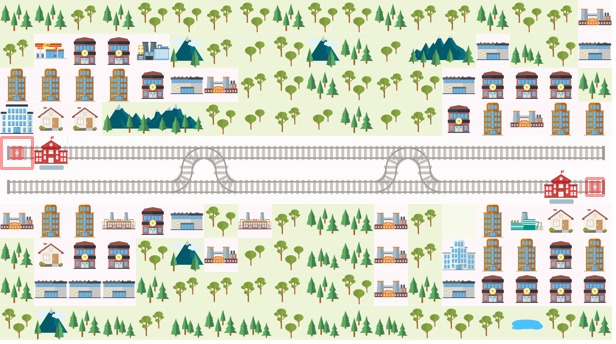

Timestep 279, total score = -624.0
All done! It took 279 timesteps and the final score was -624.0.


In [3]:
run_episode(test_env)